In [1081]:
import plotting
import importlib
importlib.reload(plotting)
import numpy as np
import transforms
import sampling
importlib.reload(sampling)
import matplotlib.pyplot as plt
import sys
import scipy
#np.set_printoptions(suppress=True)
import chernoff
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize)
import methods
import prop
importlib.reload(prop)
import pipeline
importlib.reload(pipeline)
import chernoff
importlib.reload(chernoff)

<module 'chernoff' from '/home/adl/University/IV/M4R/chernoff.py'>

In [1082]:
np.array([1,0,1]) == 1

array([ True, False,  True])

In [1094]:
ga,gb = 1,0.9
pi = 0.2
N = 500
rho = 1
#for n in [64,128,256,512,1024,2048,4096]:
gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [ga,0,1/gb])
print(np.mean(sampling.truncated_sample(scipy.stats.gamma, [ga,0,1/gb], 1, 100_000)))
true_0 = np.concatenate((np.zeros(int(N * pi)), np.ones(N - int(N * pi)))).reshape(1, -1)
model = sampling.WSBM(f"$\\Gamma[{ga},{gb}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))

0.42535153477113524


In [1084]:
null_p,alt_p = 0.5, 0.45
bernoulli_dists, bernoulli_params = [
        [[scipy.stats.bernoulli,scipy.stats.bernoulli], [scipy.stats.bernoulli,scipy.stats.bernoulli]],
        [[[alt_p],[null_p]], [[null_p], [alt_p]]]
    ]
unweighted_model = sampling.WSBM(f"Bernoulli[{null_p},{alt_p}]", bernoulli_dists, bernoulli_params, np.array([pi,1 - pi]))

In [1085]:
import random
def Sigma(model, n):
    graphs = model.multi_sample(rho, 100_000, n)
    B,_,C = model.find_distribution_statistics(graphs)
    B[0][1] = 0.5; B[1][0] = 0.5; B[1][1] = 0.5
    B[0][1] = B[1][0]
    C[0][1] = C[1][0]
    evals,evecs = scipy.linalg.eigh(B)
    
    XB = evecs @ np.sqrt(np.abs(np.diag(evals)))
    delta = np.zeros((2,2))
    for iter in range(10_000):
        z = np.array([0 if random.random() < pi else 1 for _ in range(n)])
        Xmat = np.array([XB[i] for i in z])
        delta += Xmat.T @ Xmat
    delta /= 100_000
    deltainv = np.linalg.inv(delta)

    #print (XB)
    IPQ = np.array([[-1 if evals[0] < 0 else 1,0],[0,-1 if evals[1] < 0 else 1]])
    #print (B - XB @ IPQ @ XB.T)

    mid_part_0 = np.zeros((2,2))
    mid_part_0 += pi * C[0][0] * XB[0] @ XB[0].T
    mid_part_0 += (1-pi) * C[0][1] * XB[1] @ XB[1].T

    mid_part_1 = np.zeros((2,2))
    mid_part_1 += pi * C[1][0] * XB[0] @ XB[0].T
    mid_part_1 += (1-pi) * C[1][1] * XB[1] @ XB[1].T

    sigma_0 = IPQ @ deltainv @ mid_part_0 @ deltainv @ IPQ
    sigma_1 = IPQ @ deltainv @ mid_part_1 @ deltainv @ IPQ
    return sigma_0, sigma_1

np.array(Sigma(model, 500))


array([[[0.09571616, 0.00845356],
        [0.00845356, 0.00074661]],

       [[0.09646684, 0.00851986],
        [0.00851986, 0.00075247]]])

(2, 1000)


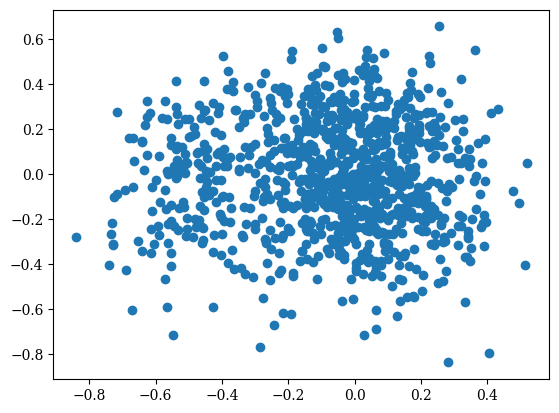

In [1086]:
def spectral_embed(x):
    x = scipy.stats.norm.ppf(x)
    x -= np.mean(x)
    svd_1d = sampling.SpecEmbed(d=2)
    sums = svd_1d.fit_transform(x, True).T
    return sums

emb = spectral_embed(model.sample(1000, 1).graph)
print (emb.shape)
plt.scatter(emb[0,:],emb[1,:])

In [1087]:
graph = model.multi_sample(rho, 1, 100)[0].graph
scipy.linalg.eigh(graph)[0]

array([-5.54183119e+00, -5.47282406e+00, -4.96946099e+00, -4.86531566e+00,
       -4.63726278e+00, -4.56183651e+00, -4.41962205e+00, -4.31068645e+00,
       -4.15582164e+00, -4.09256156e+00, -3.93903924e+00, -3.83493964e+00,
       -3.79968756e+00, -3.63597180e+00, -3.47419133e+00, -3.35655340e+00,
       -3.31743601e+00, -3.11542814e+00, -2.91671392e+00, -2.87438326e+00,
       -2.80200272e+00, -2.74256078e+00, -2.70297795e+00, -2.42774321e+00,
       -2.35538130e+00, -2.24269837e+00, -2.15373881e+00, -2.08517691e+00,
       -1.90941924e+00, -1.83436792e+00, -1.73866618e+00, -1.70721673e+00,
       -1.54481376e+00, -1.43245562e+00, -1.34172169e+00, -1.20313890e+00,
       -1.18098527e+00, -1.00512049e+00, -9.62132688e-01, -8.86028761e-01,
       -8.12275219e-01, -7.89875466e-01, -7.41980678e-01, -5.63139994e-01,
       -4.14620812e-01, -2.94100108e-01, -1.70631129e-01, -1.00106629e-01,
       -4.21119948e-02,  9.27685100e-02,  1.49122994e-01,  1.80726873e-01,
        2.71463747e-01,  

In [1088]:
np.prod([[1,2],[3,4]], axis = 1)

array([ 2, 12])

In [1089]:
import refinements
importlib.reload(refinements)

<module 'refinements' from '/home/adl/University/IV/M4R/refinements.py'>

In [1090]:
local_graph = model.sample(1000, 0.1)
uperm,perm = local_graph.permute(False, True)

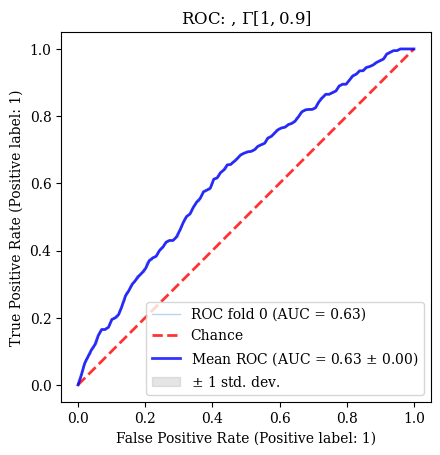

In [1091]:
BP   = prop.VariantBeliefProp(model, m = 2, CUTOFF=200)
MFV  = prop.MeanFieldVariational(model, m = 1, CUTOFF=200)
GIBB = pipeline.GibbsSampler(model, m = 0)
UMFV = prop.UnweightedMeanFieldVariational(unweighted_model, m = 50, CUTOFF=200)
SVD  = prop.SpectralEmbedding(model)
SVDU = prop.SpectralEmbeddingNoCenter(model)
SVDE = prop.SpectralEmbeddingNoLog(model)
SVDA = prop.SpectralEmbeddingInferAvg(model,inv=False)
DIAG = prop.DiagEmbed(model)

#MFV.test_roc(model, 0.5, n = 1, N = 500)
true_0 = np.concatenate((np.zeros(int(1000 * pi)), np.ones(1000 - int(1000 * pi))))[perm]
preds = refinements.gibbs(local_graph.graph, np.ones(1000) * pi, model, 1_000, 3_000)
#SVD.test_roc(model, 0.05, n = 1)
plotting.ROC_plot(np.repeat(true_0.reshape(1, -1),1,axis=0), preds.reshape(1,-1), f", {model.dist_label}")

In [788]:
1 / np.array([2,3])

array([0.5       , 0.33333333])

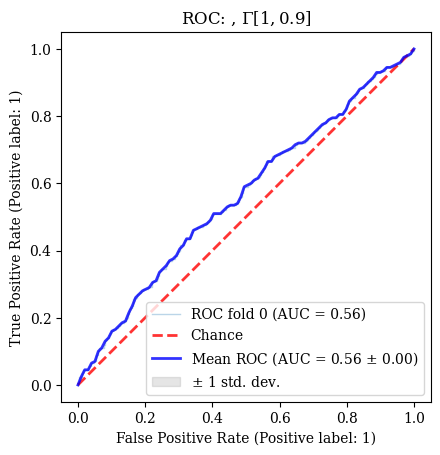

In [573]:
true_0 = np.concatenate((np.zeros(int(1000 * pi)), np.ones(1000 - int(1000 * pi)))).reshape(1, -1)
plotting.ROC_plot(np.repeat(true_0,1,axis=0), preds.reshape(1,-1), f", {model.dist_label}")

2 (2, 1000)


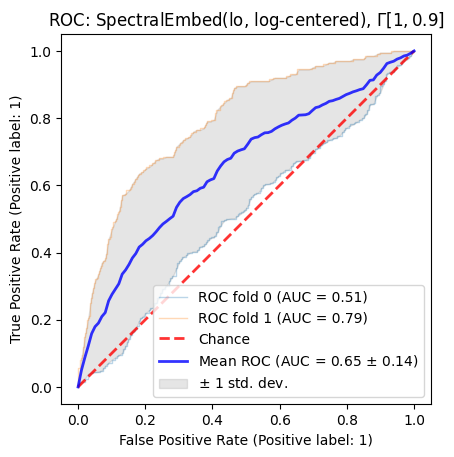

In [ ]:
def WSBM_distbn(A, B, C, pi, d):
    P = B[Z,:][:,Z]
    K = len(pi)
            
    # Spectral embeddings
    UA, SA, VAt = np.linalg.svd(A); VA = VAt.T
    UB, SB, VBt = np.linalg.svd(B); VB = VBt.T
    UP, SP, VPt = np.linalg.svd(P); VP = VPt.T

    XB = UB[:,0:d] @ np.diag(np.sqrt(SB[0:d]))
    XP = UP[:,0:d] @ np.diag(np.sqrt(SP[0:d]))
    XZ = XB[Z,:]
    
    # Find spectral embedding map to latent positions
    UW, _, VWt = np.linalg.svd(UP[:,0:d].T @ UA[:,0:d] + VP[:,0:d].T @ VA[:,0:d])
    W = UW @ VWt
    L = np.linalg.inv(XZ.T @ XZ) @ XZ.T @ XP
    
    X = XB @ L @ W
    
    # Covariance matrices
    XBinv = np.linalg.pinv(XB)
    Lambda = XBinv @ B @ XBinv.T
        
    Sigma = np.zeros((K,d,d))
    for i in range(K):
        for j in range(K):
            Sigma[i] += pi[j]*C[i,j]*np.outer(XB[j],XB[j])
        
    Delta = np.zeros((d,d))
    for i in range(K):
        Delta += pi[i]*np.outer(XB[i],XB[i])
   
    D = np.linalg.inv(Lambda @ Delta @ Lambda.T) @ Lambda
    SigmaX = np.zeros((K,d,d))
    for i in range(K):
        SigmaX[i] = W.T @ L.T @ D @ Sigma[i] @ D.T @ L @ W
   
    return (X, SigmaX)

def gaussian_ellipse(mean, cov):
    if mean.shape == (1,2):
        mean = np.array(mean)[0]
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    rtheta = np.arctan2(u[1], u[0])
    v = 3. * np.sqrt(2.) * np.sqrt(v)
    width = v[0]; height = v[1]
    
    R = np.array([
        [np.cos(rtheta), -np.sin(rtheta)],
        [np.sin(rtheta),  np.cos(rtheta)],
        ])    
    theta = np.deg2rad(np.arange(0.0, 360.0, 1.0))
    x = 0.5 * width * np.cos(theta)
    y = 0.5 * height * np.sin(theta)    
    x, y = np.dot(R,np.array([x, y]))
    x += mean[0]
    y += mean[1]
    
    return [x,y]

In [ ]:
def build_matrix(N,n,a,b):
    A = np.ones((N,N)) * a
    A[:n,:n] = b
    return A

def evals(N,n,a,b):
    k = n * np.sqrt(a * (a-b))
    c = n * (a - b)
    sqterm = np.sqrt((c - N * a)**2 + 4 * (c * N * a - k**2))
    return (N*a - c + sqterm)/2, (N * a - c - sqterm) / 2

def evecs(N,n,a,b):
    l1,l2 = evals(N,n,a,b)
    y1 = (l1 - N * a)/(n*np.sqrt(a*(a-b)))
    y2 = (l2 - N * a)/(n*np.sqrt(a*(a-b)))
    X = np.ones(N) * np.sqrt(a)
    Y = np.zeros(N)
    Y[:n] = np.sqrt(a - b)
    print (y1,y2)
    return X + y1 * Y,X + y2 * Y

: 

[0.42551926 0.03842359 0.23152122 0.50788948 0.24153776 0.92465047
 0.00508292 0.17416783 0.52045815 0.24721157 0.29517971 0.01995508
 0.0660094  0.1990871  0.0214585  0.59129635 0.03475695 0.14013853
 0.26214216 0.02257408]


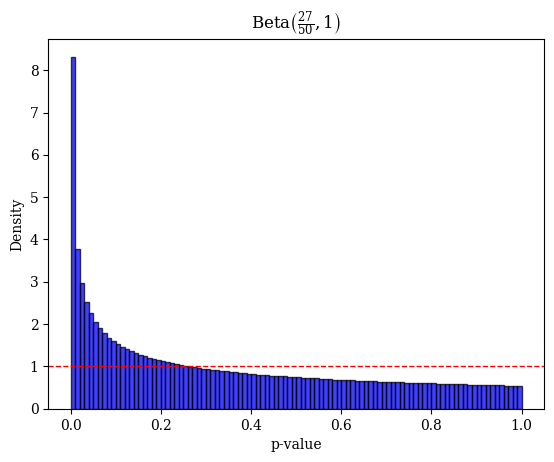

In [536]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl

# Parameters
k = 2  # degrees of freedom
M = 2  # non-centrality parameter
n_samples = 1_000_000  # number of samples

# Generate samples from the non-central chi-square distribution
#samples = np.random.noncentral_chisquare(df=k, nonc=M, size=n_samples)
ba,bb = 27/50,1
samples = scipy.stats.beta.rvs(ba,bb,size=100_000_000)
print(samples[:20])
# Compute p-values under H0
#p_values = 1 - stats.chi2.cdf(samples, df=k)
p_values = samples[samples >= 0]
p_values = p_values[p_values <= 1]
#p_values = sampling.truncated_sample(scipy.stats.gamma, [0.9,0,0.5],1)
# Plot the histogram of p-values
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'DejaVu Serif'
mpl.rcParams["mathtext.default"] = 'rm'
mpl.rcParams["mathtext.fontset"]= 'dejavuserif'
fig,ax = plt.subplots()
plt.hist(p_values, bins=100, density=True, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel('p-value')
plt.ylabel('Density')
plt.title('Beta$\\left(\\frac{27}{50},1\\right)$')
plt.axhline(1, color='red', linestyle='dashed', linewidth=1)
plt.show()

fig.savefig('beta2.svg', format='svg', dpi=1200)

In [ ]:
import matplotlib as mpl
from scipy import linalg

from sklearn import mixture
import itertools 

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title(title)

In [ ]:
p_values = sampling.truncated_sample(scipy.stats.gamma, [0.8,0,5],1)
# Plot the histogram of p-values
plt.hist(p_values, bins=50, density=True, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel('p-value')
plt.ylabel('Density')
plt.title('P-value Distribution under H1')
plt.axhline(1, color='red', linestyle='dashed', linewidth=1)
plt.show()

: 

In [ ]:
import random

: 

In [ ]:
N = 10
n = 4
a = 0.5
b = 0.3

M = build_matrix(N,n,a,b)
orig = list(range(N))
random.shuffle(orig)
M = M[orig]
M = M[:, orig]
#print (np.linalg.eig(M))
ev1,ev2 = evecs(N,n,a,b)
v1,v2=evals(N,n,a,b)
print (v1/v2)
ev2 / np.linalg.norm(ev2)

: 

In [ ]:
EVS = np.linalg.eigh(M)[1].T

: 

In [ ]:
EVS

: 

In [ ]:
np.sum(np.sum(EVS[1:-1], axis = 0)[[3,5,6,9,8]])

: 

In [ ]:
import itertools
thing = np.sum(EVS[1:-1], axis = 0) 
for partition in itertools.product([True,False], repeat = 10):
    comp = [not b for b in partition]
    s1,s2 = np.sum(thing[partition]),np.sum(thing[comp])
    if abs(s1) < 1e-10 and abs(s2) < 1e-10:
        print (partition)

: 

In [ ]:
thing = np.sum(EVS[1:3], axis = 0) 
np.sum(thing[[2,4,6,9]]),np.sum(thing[[0,1,3,5,7,8]])

: 

In [ ]:
np.sum(np.sum(EVS[1:-1], axis = 0)[[0,1,2,4,7]])

: 

In [ ]:
-2.33652029e-01 * 1.0845722960908555

: 

In [ ]:
-1.294550841276473 * 4.10012309e-01

: 

In [ ]:
EVS[5] @ EVS[6]

: 

In [ ]:
6.61324263e-01-7.45376087e-01

: 

In [ ]:
ev3 = np.linalg.eig(M)[1].T[1]

: 

In [ ]:
ev3

: 

In [ ]:
ev2 / np.linalg.norm(ev2)

: 

: 

In [ ]:
(M @ ev3) / ev3

: 

In [ ]:
2.78463157e-01/3.31096622e-01

: 

: 

In [ ]:
MFV.test_roc(model, 1, n = 2)

: 

In [ ]:
UMFV.test_roc(unweighted_model, 1, n = 2)

: 

In [ ]:
%matplotlib widget
for ga,gb in [(0.5,0.5)]:
    pi = 0.1
    N = 500
    rho = 0.2
    #for n in [64,128,256,512,1024,2048,4096]:
    gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [ga,0,1/gb])
    true_0 = np.concatenate((np.zeros(int(N * pi)), np.ones(N - int(N * pi)))).reshape(1, -1)
    model = sampling.WSBM(f"$\\Gamma[{ga},{gb}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
    BP   = prop.VariantBeliefProp(model, 3)
    SVD  = prop.SpectralEmbedding(model)
    methods.compare_methods(model, BP, SVD, n = 5)

: 

In [ ]:
%matplotlib widget
methods.compare_methods(model, SVDA, SVD)

: 

In [ ]:
methods.compare_methods(model, BP, SVD)

: 

In [ ]:
methods.compare_methods(model, BP, SVDA)

: 

: 

In [ ]:
X1,Y1,Z1=plotting.ROC_surface_data(np.repeat(np.repeat(true_0,3,axis=0).reshape(1,3,-1),10,axis=0), SVDA.cache[k][1])
X2,Y2,Z2=plotting.ROC_surface_data(np.repeat(np.repeat(true_0,3,axis=0).reshape(1,3,-1),10,axis=0), SVD.cache[k][1])
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set(
    xlabel="edge probability", ylabel="false positive rate", zlabel="true positive rate"
)
plotting.plot_ROC_surface(X1,Y1,Z1 - Z2, f"Advantage of =",fig,ax,plotting.cm.get_cmap('bwr_r'))
plt.show()

: 

In [ ]:
plotting.ROC_plot(np.repeat(true_0,3,axis=0).reshape(3,-1), SVD.cache[k][1][9], "h")
plt.show()

: 

In [ ]:
plt.plot(Z2[1])
plt.show()

: 

In [ ]:
np.set_printoptions(suppress=True)
SVDA.test_roc(model, 0.9, 500)

: 

In [ ]:
def compute_marginal(psi_0, psi_1, G, C, n_0, n_1):
    psi = np.zeros(len(G))

def belief_prop(psi_0, psi_1, G, C, n_0, n_1):
    npsi_0, npsi_1 = np.zeros(psi_0.shape), np.zeros(psi_1.shape)

    for i in range(len(G)):
        for j in range(len(G)):
            component_0 = n_0
            component_1 = n_1
        
            for k in range(len(G)):
                if G[k][i] > 0 and k != j:
                    component_0 *= (C[0][0] * psi_0[k][i] + C[1][0] * psi_1[k][i])
                    component_1 *= (C[0][1] * psi_0[k][i] + C[1][1] * psi_1[k][i])
                else:
                    component_0 *= 1 - (1/len(G)) * (C[0][0] * psi_0[k][i] + C[1][0] * psi_1[k][i])
                    component_1 *= 1 - (1/len(G)) * (C[0][1] * psi_0[k][i] + C[1][1] * psi_1[k][i])

            Z = component_0 + component_1
            npsi_0[i][j] = component_0 / Z
            npsi_1[i][j] = component_1 / Z
    return npsi_0, npsi_1

C = len(G) * np.array([
    [0.6, 0.3],
    [0.3, 0.3] 
], dtype="float")

n_0 = 0.4
n_1 = 1 - n_0
psi_0 = np.ones(G.shape) * n_0
psi_1 = np.ones(G.shape) * n_1

for _ in range():
    psi_0, psi_1 = belief_prop(psi_0, psi_1, G, C, n_0, n_1)

psi_0, psi_1


: 

In [ ]:
def belief_prop(psi_0, psi_1, G, C, n_0, n_1):
    npsi_0, npsi_1 = np.zeros(psi_0.shape), np.zeros(psi_1.shape)
    N = len(G)
    K_1_0 = C[0][0] * n_0 + C[0][1] * n_1
    K_1_1 = C[1][0] * n_0 + C[1][1] * n_1
    K_2_0 = N / (N - C[0][0] * n_0 - C[0][1] * n_1)
    K_2_1 = N / (N - C[1][0] * n_0 - C[1][1] * n_1)
    for i in range(len(G)):
        for j in range(len(G)):
            component_0 = n_0
            component_1 = n_1
            for k in range(len(G)):
                if G[k][i] > 0 and k != j:
                    component_0 *= 1 + K_1_0 * (C[0][0] * psi_0[k][i] + C[1][0] * psi_1[k][i])
                    component_1 *= 1 + K_1_1 * (C[0][1] * psi_0[k][i] + C[1][1] * psi_1[k][i])
                else:
                    component_0 *= 1 - (1/len(G)) * K_2_0 * (C[0][0] * psi_0[k][i] + C[1][0] * psi_1[k][i])
                    component_1 *= 1 - (1/len(G)) * K_2_1 * (C[0][1] * psi_0[k][i] + C[1][1] * psi_1[k][i])

            Z = component_0 + component_1
            npsi_0[i][j] = component_0 / Z - n_0
            npsi_1[i][j] = component_1 / Z - n_1
            
    return npsi_0, npsi_1


G = np.array([
    [0, 0, 0, 1],
    [1, 0, 0, 1],
    [1, 1, 0, 0],
    [0, 1, 1, 0]
], dtype="float")

C = len(G) * np.array([
    [0.2, 0.5],
    [0.5, 0.5] 
], dtype="float")

n_0, n_1 = 0.3, 0.7
psi_0 = np.zeros(G.shape) * n_0
psi_1 = np.zeros(G.shape) * n_1

belief_prop(psi_0, psi_1, G, C, n_0, n_1)


: 